# Chapter 2: Programming Probablistically

The basic idea is to specify models using code and solve them more or less automatically using numerical/computational techniques.

The main packages are 
* pyMC3 - a PPL package
* arViz - a package for visualising the results of models and helping us interpret them

In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
# az.style.use('arviz-darkgrid')
plt.style.use('seaborn-darkgrid')

## Probablistic Programming Language (PPL)
In Bayesian stats we have knowns (__data__) and unknowns (__parameters__) . The Bayesian process is to estimate the latter, and condition it on the former to reduce the uncertainty of the unknowns. We assign probability distirbutions to the unknowns as the __prior__, then condition it on data using Bayes' theorem to get a __posterior__.

The analytical method of doing this is VERY difficult, involving solving complicated integrals. There were methods for solving posteriors algebraically for some specific combinations of priors and likelihoods (conjugate priors), but we were very limited in our ability to stray outside these, and therefore in how we specified our models.

It's only recently that computational power and the numerical methods for solving these equations have advanced to the point where we can overcome these limitations. PPLs like pyMC3 have been developed which automate the inference process. You specify the model concisely using the PPL, and then hit the 'inference button'. This allows users to automate the inference process, they don't need to worry about solving complicated equations, instead they can focus on designing good models.

## PyMC3 Primer


## Coin flipping with PyMC3

Let's rebuild our coin flipping model in PPL using pyMC3

In [2]:
# data generator
np.random.seed(123)
N = 4
θ_real = 0.35 # unknown value in the real world
data = stats.bernoulli.rvs(p=θ_real, size=N)

with pm.Model() as coin_flip_model:
    θ = pm.Beta('θ', alpha=1.0, beta=1.0) # our prior for θ is a uniform, or Beta(1,1)
    y = pm.Bernoulli('y', p=θ, observed = data) # likelihood, using a Bernoulli with p set to θ, and data input
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|███████████████| 3000/3000 [00:05<00:00, 564.76draws/s]


The sampling engine (NUTS in this case) runs 2 parallel chains of sampling (so we get 2 results) for each parameter. (Note that y is an observed variable representing the data - it's not being sampled from because we already have the values)

We specified 1000 samples, and each chain 'tunes' it's sampling algorithm with 500 samples (you can set this with the `tune=` argument). So in total there are 1500x2=3000 samples

## Summarising the posterior
### plot_trace
The first thing we want to do is plot the posterior using ArviZ

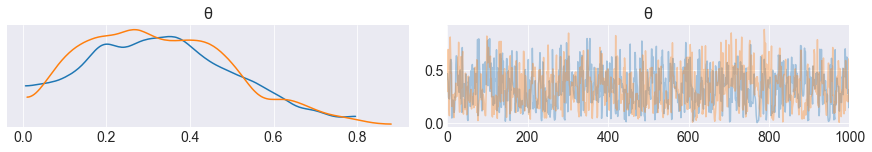

In [3]:
az.plot_trace(trace)
plt.show()

The 2 graphs resulting show
* on the left is the __Kernel Density Estimate__, KDE. It's like a smooth histogram of the sample results, and can be thought of as the plausible results of the sample. You can compare the results of this with what we analytical results of the previous chapter (reproduced below)
* on the right is the results of the individual samples from 0 to 1000.

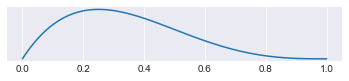

In [4]:
y = np.sum(data)
N = len(data)
θ = stats.beta(a=1+y, b=1+N-y)
x = np.linspace(0,1,100)
plt.figure(figsize=(6,1))
plt.plot(x, θ.pdf(x))
plt.yticks([])
plt.show()

### Summary
Arviz can also provide a numerical summary of the trace, outputting a dataframe with
* mean
* sd
* 94% HPD (via the 3% and 97%)
* other entries releted to samples themselves, which we'll look at in _Chapter 8, Inference Engines_

In [5]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
θ,0.33,0.18,0.0,0.02,0.64,847.0,1.0


### Plot_posterior
This plots the actual result, the numerically calcluated posterior, again as a KDE (or histogram for discretes), including the HPD with (as a default) 94% interval. You can change the CI with `credible_interval` argument.

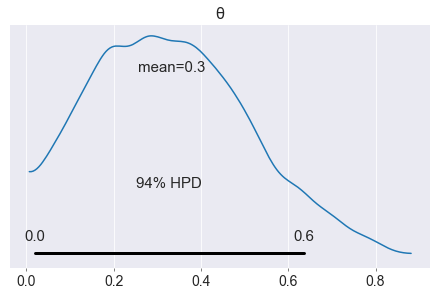

In [6]:
az.plot_posterior(trace)
plt.show()

### Decisions
Using all this info you can make informed decisions and draw conclusions. For example here, we might say that the coin does seem to be tail-biased, but the 94% HPD does include 0.5, so we cant rule out the possibility that this is a fair coin. We should collect more data if we want a sharper decision.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|███████████████| 3000/3000 [00:05<00:00, 547.15draws/s]


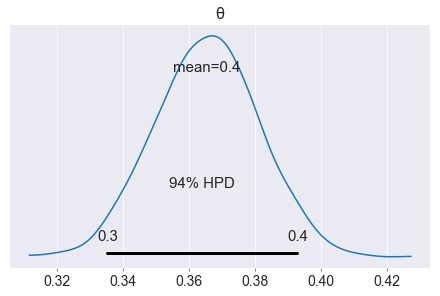

In [7]:
N = 1000
θ_real = 0.35 
data = stats.bernoulli.rvs(p=θ_real, size=N)

with pm.Model() as coin_flip_model:
    θ = pm.Beta('θ', alpha=1.0, beta=1.0) 
    y = pm.Bernoulli('y', p=θ, observed = data) 
    trace2 = pm.sample(1000)
az.plot_posterior(trace2)
plt.show()

For the above we ran 1000 trials, and we get a mean of 0.3 and a 94% HPD range of 0.3-0.4 - her we can say fairly categorically that this is not a fair coin

### Region of Practical Equivalence (ROPE)
Because our view of the parameter $\theta$ is defined as a continuous distribution, not a discrete distribution or just a logical value, our estimate for $\theta$ could never be exactly 0.5. So if our question is 'is this coin fair?', the quantitative equivalent of this isn't 'is $\theta=0.5$?' but 'Is $\theta$ likely to include a region around 0.5 that we can practically consider as meaning it's 'fair'?'

In other words we need to specify our parameters for fairness. Here we might say that any value between 0.45 and 0.55 can be considered fair. This is our ROPE.

You can then compare the ROPE with the HPD. If the HPD and ROPE don't overlap we can say the coin isn't fair. If the ROPE contains the HPD, we can say it's fair. If they partially overlap we can't draw a conclusion.

>A ROPE is an arbitrary interval we choose based on background knowledge. Any value inside this interval is assumed to be of practical equivalence.

There's no autofit rule for how you set your ROPE or HPD - it's subjective.

You can plot the ROPE on your posterior plot, as well as a reference line at a given value, which also prints the the proportion of the posterior which is above and below that reference. 

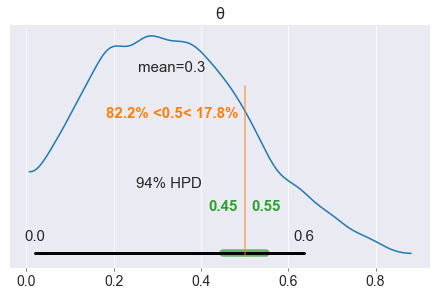

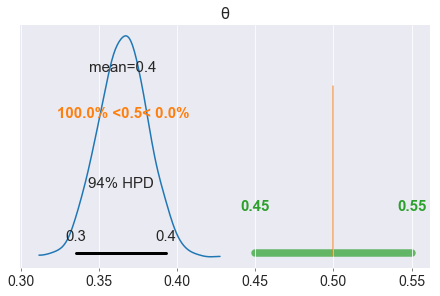

In [8]:
az.plot_posterior(trace, rope=[0.45, .55], ref_val=0.5)
az.plot_posterior(trace2, rope=[0.45, .55], ref_val=0.5)
plt.show()

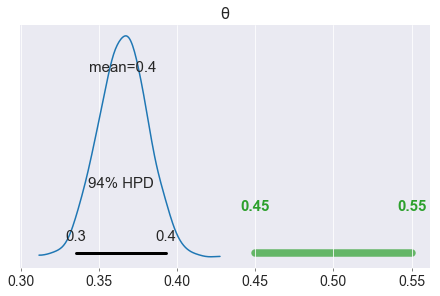

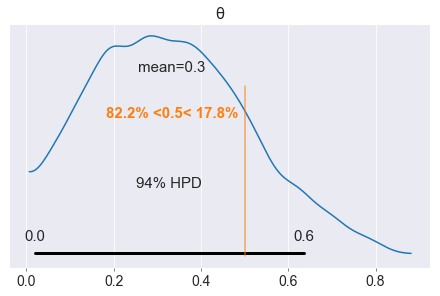

In [9]:
az.plot_posterior(trace2, rope=[0.45, .55])
az.plot_posterior(trace, ref_val=0.5)
plt.show()

### Loss Functions
Loss functions are an alternative way to make decisions from the posterior.

The key idea is to capture how different the true parameter value and the estimated value are. The larger the loss function, the worse the estimation is (within the confines how how the loss function defines it). 

There are a few different loss functions, the ones we'll use here are the quadratic loss $(\theta-\hat{\theta})^2$, and the absolute loss $|\theta-\hat{\theta}|$, where $\theta$ is the true value of theta and $\hat{\theta}$ is the estimated value of theta.

Obviously we don't know true theta. But we can find the value of theta which would minimise the mean loss by setting theta to every value between 0 and 1 (the valid values for the theta in our case), and for each in turn calculating the loss (here we'll take the mean of all our individual losses our our posterior estimates).

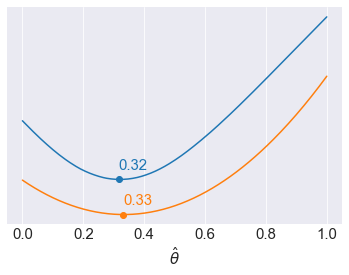

In [10]:
θ_value = trace['θ']
x = np.linspace(0,1,200)
lossfunc_a = [np.mean(abs(i-θ_value)) for i in x]
lossfunc_b = [np.mean((i-θ_value)**2) for i in x]

for lossfunc, color in zip([lossfunc_a,lossfunc_b],['C0','C1']):
    minimum = np.argmin(lossfunc)
    plt.plot(x, lossfunc, color)
    plt.plot(x[minimum],lossfunc[minimum], 'o', color=color)
    plt.annotate('{:.2f}'.format(x[minimum]), 
                 (x[minimum],lossfunc[minimum]+0.03), 
                color = color, fontsize=15)

plt.yticks([])
plt.xticks(fontsize=15)
plt.xlabel(r'$\hat\theta$', fontsize=15)
plt.show()

Note the the values, 0.32 and 0.33, correspond to the median and mean of `θ_value` respectively. This isn't a co-incidence. By reducing $\theta$ to a point estimate we are implicitly choosing and calculating a loss function of some kind. So why not do it explicitly, so you can be specific about the parameters. In particular you can be explicit about asymmetries, where the cost of upsides or downsides are not equal. And because the posterior is in the form of numerical samples, not a function, you can use any loss function you want.

In [11]:
print('Median: {:.2f}'.format(np.median(θ_value)),'Mean: {:.2f}'.format(np.mean(θ_value)))

Median: 0.32 Mean: 0.33


## Gaussian and Student's t Models
### Gaussian
Normal is useful because of the CLT, i.e. when you take a sample, if that sample is large enough the sample average will be normally distributed around the true mean.

Normals occur in nature pretty often, and have the benifit of being fairly simple. 

### Gaussian example
Here's a dataset of observations of chemical shift, some obscure physics thing related to nuclear magnetic resonance. Note the 2 'outliers'.

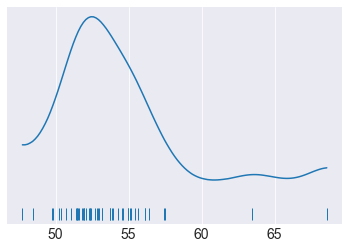

In [12]:
data = pd.read_csv('data/chemical_shifts.csv',header=None)
az.plot_kde(data, rug=True)
# x = np.linspace(45,65,100)
# y = stats.norm(52.9, 3).pdf(x)/5
# plt.plot(x,y,color='C1')
plt.yticks([])
plt.show()

Let's initially work on the basis that this can be approximated with a normal distribution. Let's try to find distirbutions for the parameters mu and sigma. For the mean we'll use a uniform, and for sd a half normal (since it must be positive)

$$\mu \sim U(l,h)$$

$$\sigma \sim |N(0,\sigma_\sigma)|$$

$$y \sim N(\mu, \sigma)$$

For our initial prior parameters, we'll set l=40 and h=70, which covers all of the obervations. Set $\sigma_\sigma=10$, just a large (therefore vague) number.

In [13]:
with pm.Model() as chem_shift_model:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_csm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|███████████████| 3000/3000 [00:05<00:00, 547.95draws/s]


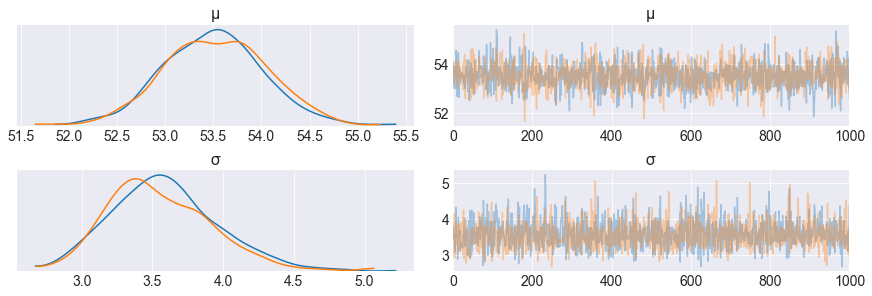

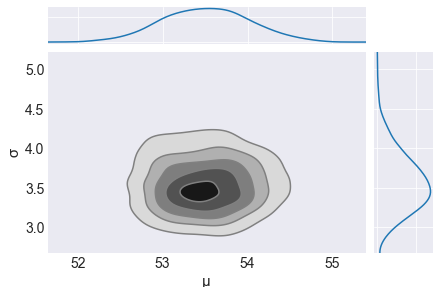

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,53.50,0.53,0.01,52.57,54.55,1520.0,1.0
σ,3.57,0.37,0.01,2.89,4.25,1862.0,1.0


In [14]:
az.plot_trace(trace_csm)
az.plot_joint(trace_csm, kind='kde',fill_last=False)
plt.show()
az.summary(trace_csm)

Since the posterior here has 2 parameters, the trace is bi-dimensional and the plot has output graphs of the 2 parameters - these are called the __marginal distributions__ of each paramter. In addition to the trace plot we've also output the joint plot, which shows each marginal distribution as well as a contour map of both of them combined.

Now lets do our PPCs. Using `sample_posterior_predictive` we can specify the number of samples to take. Each sample will have the same number of data points as the original dataset we passed in the model. 

Thus function returns a dictionary with the keys being the observed value (y), and the values an array of shape (samples, size) with the prediction results. You can then pull out the values and plot the ppc results against the original data. In the below plot, the black line is the KDE of the data, the other lines are plots of all 100 of the posterior predictives.

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 1234.57it/s]


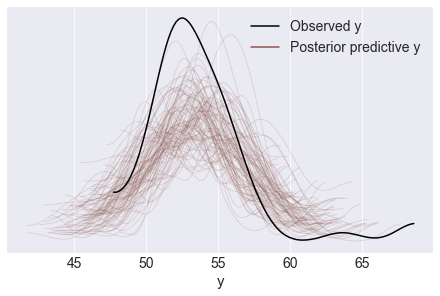

In [15]:
y_post_pred = pm.sample_posterior_predictive(trace_csm, samples=100, model=chem_shift_model)
data_ppc = az.from_pymc3(trace=trace_csm, posterior_predictive=y_post_pred)
az.plot_ppc(data_ppc, mean=False)
plt.show()

From this it looks like the mean of the posterior predictive is slightly to the right and the sd is slightly larger than the actual data. In this case it's a result of the outliers - they're skewing the result.

Can we say that the result is an acceptable model? That's a subjective question.

Let's say we're not satisfied and look to improve the model.

### Robust inferences
We're using a normal distribution to approximate y. Is that sensible? It seems a bit forced given those outliers. We saw that the posterior predictive 'overcorrected' for these using a normal approximation. We could argue that the outliers have excessive weight. 

We could declare them outliers and basically ignore them, or we could 'fix' them. That might be valid. We can even automate outlier elimination with outlier rules. But lets say we don't want to eliminate of fix them. Instead we change the distribution we use as an approximation.

### Student's T
Gaussian is like a normal distribution with an additional parameter $\nu$, degrees of freedom, or the __normality parameter__, in the interval 0-$\infty$. It determines how normal the distribution is, how fat the tails are.

Normal is actually equivalent to special case of T, where $\nu = \infty$.

Another special case is the __Cauchy__, or __Lorentz__ distribution, with a $\nu=1$. That's a heavy tailed distribution, with 95% of observations within 12.7 SDs of the mean  

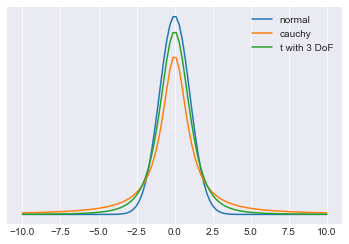

In [16]:
x = np.linspace(-10,10,100)
y1 = stats.norm(0,1).pdf(x)
y2 = stats.cauchy(0,1).pdf(x)
y3 = stats.t(loc=0,scale=1,df=3).pdf(x)
plt.plot(x,y1, label='normal')
plt.plot(x,y2, label='cauchy')
plt.plot(x,y3, label='t with 3 DoF')
plt.legend()
plt.yticks([])
plt.show()

The T distr has a couple of interesting properties:
* when 𝜈 <= 1, there's no mathematically defined mean. If you were to sample from it and try to calculate a mean, it would wander around aimlessly.
* when 𝜈 <= 2 there is no defined variance. (seem contradictory in notes?)

Let redo our model. We need the new parameter 𝜈, lets give it an exponential distirbution with mean 30, i.e. rate lambda 1/30. 30 would be considered an 'uninformative' value for nu, because it's close to the normal.

$$\mu \sim U(l,h)$$

$$\sigma \sim |N(0,\sigma_\sigma)|$$

$$\nu \sim Exp(\lambda)$$

$$y \sim T(\mu, \sigma, \nu)$$

In [17]:
with pm.Model() as chem_shift_model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd = 10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_csm_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, μ]
Sampling 2 chains: 100%|███████████████| 3000/3000 [00:06<00:00, 428.94draws/s]


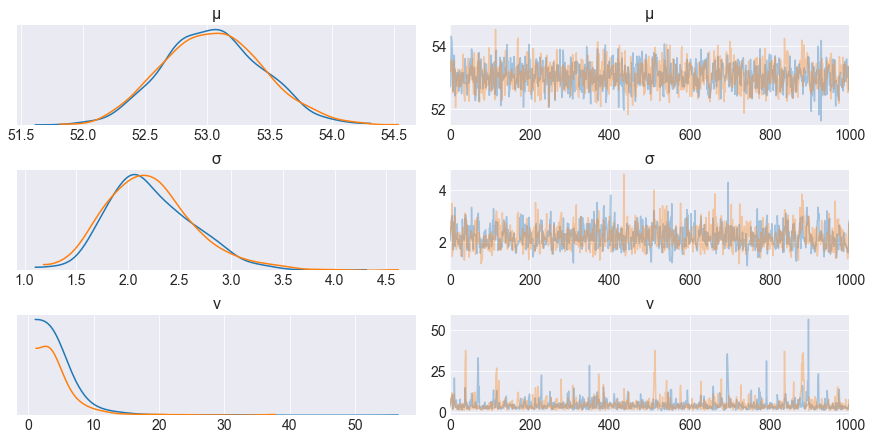

In [18]:
az.plot_trace(trace_csm_t)
plt.show()

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 1562.50it/s]


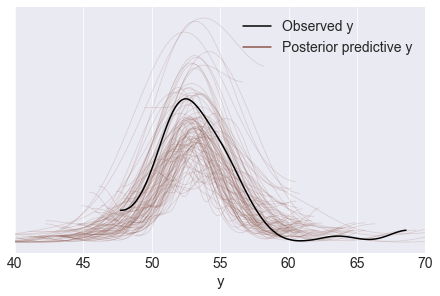

In [19]:
y_post_pred = pm.sample_posterior_predictive(trace_csm_t, samples=100, model=chem_shift_model_t)
data_ppc = az.from_pymc3(trace=trace_csm_t, posterior_predictive=y_post_pred)
az.plot_ppc(data_ppc, mean=False)
plt.xlim([40,70])
plt.show()

In [20]:
az.summary(trace_csm_t)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,53.04,0.40,0.01,52.31,53.79,1222.0,1.0
σ,2.22,0.42,0.01,1.51,3.03,986.0,1.0
ν,4.86,4.19,0.06,1.25,10.64,691.0,1.0


## Comparing groups and effect size

## Hierarchical models and shrinkage